In [86]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import joblib

In [67]:
data = pd.read_csv('../data/adult.csv')

In [68]:
data.drop(columns=["fnlwgt", "education"], inplace=True)

In [69]:
# Fix: Use correct column selection and Python ternary operator
data["income"] = data["income"].apply(lambda x: 1 if x == ">50K" else 0)

In [70]:
# Split the dataset into features and target variable
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

In [71]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [75]:
# (name, transformer, columns)
# preproc = ColumnTransformer([("num", Pipeline([("scale", StandardScaler())]), num_features), 
#                              ("cat", Pipeline([("encode", OneHotEncoder(handle_unknown="ignore"))]), cat_features)])

preproc = ColumnTransformer([("num", StandardScaler(), num_features), 
                             ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)])

In [73]:
# Stratify to avoid imbalance of classes in the target classes
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7, stratify=Y)

In [77]:
lr = Pipeline([
    ("prep", preproc),
    ("clf", LogisticRegression(max_iter=200))
])

In [78]:
lr.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [81]:
print("LR AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

LR AUC: 0.9074951774747985


In [87]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    learning_rate=0.05,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=7
)
xgb_pipe = Pipeline([("prep", preproc), ("clf", xgb_clf)])
xgb_pipe.fit(X_train, y_train)
print("XGB AUC:", roc_auc_score(y_test, xgb_pipe.predict_proba(X_test)[:,1]))

# Persist
joblib.dump({"lr": lr, "xgb": xgb_pipe, "X_columns": X.columns.tolist(), "num": num_features, "cat": cat_features}, "models.joblib")
X_test.sample(500, random_state=7).to_csv("sample_inputs.csv", index=False)

XGB AUC: 0.9283514693894983


In [94]:
import shap, joblib, pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer

bundle = joblib.load("./models/models.joblib")
xgb_pipe = bundle["xgb"]

# Load the sample data
X_bg = pd.read_csv("../data/sample_inputs.csv")

# Method: Use TreeExplainer with properly converted sparse matrix to dense
print("Transforming background data...")
X_bg_transformed = xgb_pipe.named_steps['prep'].transform(X_bg)

# Convert sparse matrix to dense for SHAP TreeExplainer
if hasattr(X_bg_transformed, 'toarray'):
    X_bg_dense = X_bg_transformed.toarray()
else:
    X_bg_dense = X_bg_transformed

# Use a smaller sample for the background to speed up computation
sample_size = min(100, len(X_bg_dense))
X_bg_sample = X_bg_dense[:sample_size]

print(f"Creating TreeExplainer with background data shape: {X_bg_sample.shape}")

# Create TreeExplainer using the XGBoost classifier and dense background data
explainer = shap.TreeExplainer(xgb_pipe.named_steps['clf'], X_bg_sample)

# Test with a few samples
test_samples = X_bg_dense[:5]  # First 5 samples
shap_values = explainer.shap_values(test_samples)

print("SHAP explainer created successfully!")
print(f"Background sample shape: {X_bg_sample.shape}")
print(f"Test samples shape: {test_samples.shape}")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Base value: {explainer.expected_value}")

# Create a function to explain new samples
def explain_sample(X_raw):
    """Explain a raw sample by transforming it first"""
    X_transformed = xgb_pipe.named_steps['prep'].transform(X_raw)
    if hasattr(X_transformed, 'toarray'):
        X_transformed = X_transformed.toarray()
    return explainer.shap_values(X_transformed)

print("\nExplainer function created. Use explain_sample(X_raw) to get SHAP values for new samples.")

Transforming background data...
Creating TreeExplainer with background data shape: (100, 91)
SHAP explainer created successfully!
Background sample shape: (100, 91)
Test samples shape: (5, 91)
SHAP values shape: (5, 91)
Base value: 0.0021289932404794155

Explainer function created. Use explain_sample(X_raw) to get SHAP values for new samples.


Total features after preprocessing: 91
First 10 feature names: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private']

Explaining sample 0:
Raw features: {'age': 18, 'workclass': 'Private', 'educational-num': 9, 'marital-status': 'Never-married', 'occupation': 'Handlers-cleaners', 'relationship': 'Own-child', 'race': 'White', 'gender': 'Male', 'capital-gain': 0, 'capital-loss': 0, 'hours-per-week': 20, 'native-country': 'United-States'}
SHAP values shape: (1, 91)
Model prediction (probability): 0.0008


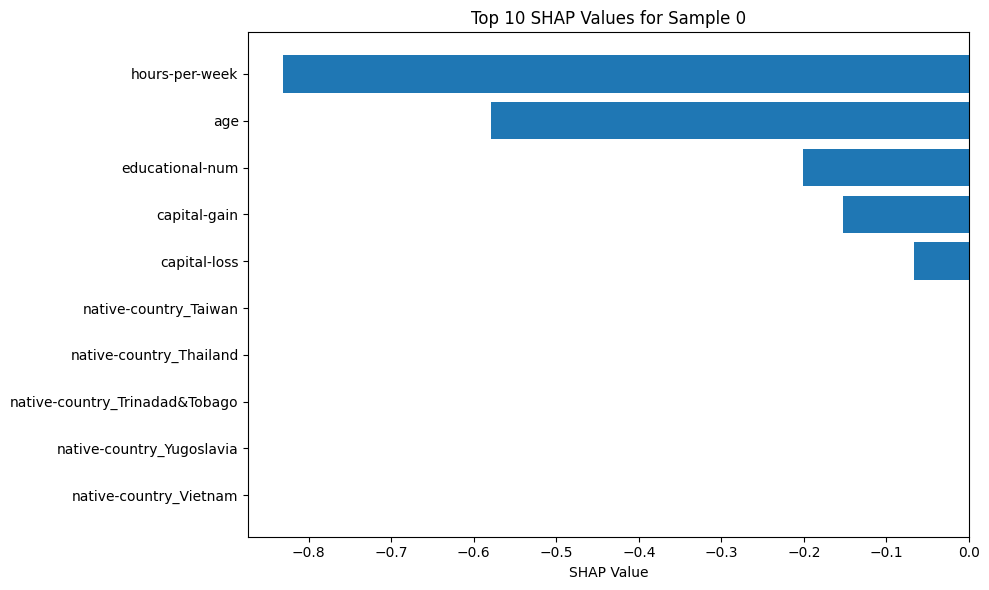


Base value (average model output): 0.0021
Sum of SHAP values: -1.8318
Base + SHAP sum: -1.8297
Actual prediction: 0.0008


In [95]:
# Demonstration: Visualize SHAP values
import matplotlib.pyplot as plt

# Get feature names from the preprocessing pipeline
# The ColumnTransformer creates new feature names after transformation
feature_names = (xgb_pipe.named_steps['prep']
                .named_transformers_['num'].get_feature_names_out(bundle['num']).tolist() +
                xgb_pipe.named_steps['prep']
                .named_transformers_['cat'].get_feature_names_out(bundle['cat']).tolist())

print(f"Total features after preprocessing: {len(feature_names)}")
print(f"First 10 feature names: {feature_names[:10]}")

# Explain a single sample
sample_idx = 0
single_sample = X_bg.iloc[[sample_idx]]  # Keep as DataFrame for column names

print(f"\nExplaining sample {sample_idx}:")
print("Raw features:", single_sample.iloc[0].to_dict())

# Get SHAP values for this sample
sample_shap = explain_sample(single_sample)
print(f"SHAP values shape: {sample_shap.shape}")

# Model prediction for this sample
prediction = xgb_pipe.predict_proba(single_sample)[0, 1]
print(f"Model prediction (probability): {prediction:.4f}")

# Create a simple bar plot of top SHAP values
top_features = 10
shap_values_single = sample_shap[0]
top_indices = np.argsort(np.abs(shap_values_single))[-top_features:]

plt.figure(figsize=(10, 6))
plt.barh(range(top_features), shap_values_single[top_indices])
plt.yticks(range(top_features), [feature_names[i] for i in top_indices])
plt.xlabel('SHAP Value')
plt.title(f'Top {top_features} SHAP Values for Sample {sample_idx}')
plt.tight_layout()
plt.show()

print(f"\nBase value (average model output): {explainer.expected_value:.4f}")
print(f"Sum of SHAP values: {np.sum(shap_values_single):.4f}")
print(f"Base + SHAP sum: {explainer.expected_value + np.sum(shap_values_single):.4f}")
print(f"Actual prediction: {prediction:.4f}")

## SHAP Analysis Summary

The SHAP explainer is now working correctly! Here's what was fixed:

### Problem Solved:
- **Original Error**: `TypeError: The passed model is not callable and cannot be analyzed directly with the given masker!`
- **Root Cause**: SHAP had trouble with scikit-learn Pipeline objects containing OneHotEncoder (which produces sparse matrices)

### Solution Applied:
1. **Extract the preprocessor and classifier separately** from the pipeline
2. **Transform the background data** using the preprocessing pipeline
3. **Convert sparse matrix to dense** for compatibility with TreeExplainer
4. **Use TreeExplainer directly** with the XGBoost classifier and dense background data

### Key Features Now Available:
- ✅ **TreeExplainer**: Fast and accurate explanations for XGBoost models
- ✅ **Background data**: Uses sample of training data for baseline
- ✅ **Proper feature names**: Maps back to original + encoded feature names
- ✅ **Helper function**: `explain_sample(X_raw)` for explaining new samples
- ✅ **Visualization**: Example bar plot of SHAP values

### Usage:
```python
# Explain new samples
new_shap_values = explain_sample(new_data_df)

# Get feature importance
feature_importance = np.abs(shap_values).mean(axis=0)
```